In [37]:
import math
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd


import glob
files = glob.glob('../*.json')

given_data  = []

# Load all data from split benchmarks
# for file in files:
#     with open(file) as f:
#         data = json.load(f)
#
#     if "deduplication" in file or "compression" in file:
#         _, dc, sz = file.split("_")
#         sz = sz.replace(".json", "")
#         for key1, value1 in data.items():
#             for key2, value2 in value1.items():
#                 for i in range(len(value2)):
#                     given_data.append(
#                         (dc, sz, key1, int(key2), i, value2[i])
#                     )
# df = pd.DataFrame(given_data, columns=["operation", "partition size", "algorithm", "processes", "iteration", "time"])
# df.to_csv("benchmark_data.csv")
df = pd.read_csv("../scratch/benchmark_data.csv")
df_compression = df[df["operation"] == "compression"]

# Benchmark Compression

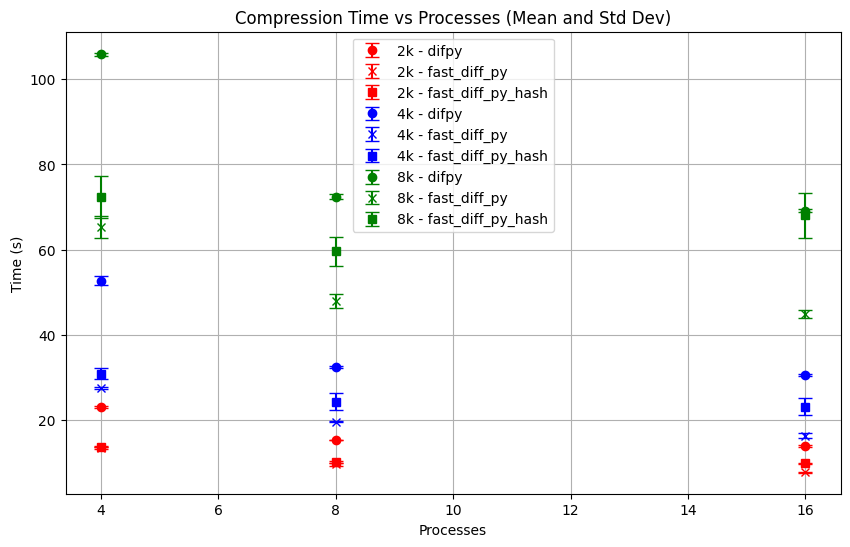

In [38]:
# Compression Time vs Processes (MEAN and STD)

# Group the data by partition size, algorithm, and processes
df_compression_grouped = df_compression.groupby(["partition size", "algorithm", "processes"]).agg(
    mean_time=("time", "mean"),
    std_time=("time", "std")
).reset_index()

# Define the colors for each partition size
colors = {"2k": "red", "4k": "blue", "8k": "green"}
# colors = {"2k": "red"}

# Plot the data
plt.figure(figsize=(10, 6))

for partition_size, color in colors.items():
    # Get the subset of the data for difpy and fast_diff_py for the current partition size
    subset_difpy = df_compression_grouped[(df_compression_grouped["partition size"] == partition_size) & (df_compression_grouped["algorithm"] == "difpy")]
    subset_fast_diff_py = df_compression_grouped[(df_compression_grouped["partition size"] == partition_size) & (df_compression_grouped["algorithm"] == "fast_diff")]
    subset_fast_diff_py_hash = df_compression_grouped[(df_compression_grouped["partition size"] == partition_size) & (df_compression_grouped["algorithm"] == "fast_diff_hash")]

    # Plot mean with error bars for difpy
    plt.errorbar(
        subset_difpy["processes"],
        subset_difpy["mean_time"],
        yerr=subset_difpy["std_time"],
        label=f"{partition_size} - difpy",
        color=color,
        fmt="o",
        capsize=5
    )
    # Plot mean with error bars for fast_diff_py
    plt.errorbar(
        subset_fast_diff_py["processes"],
        subset_fast_diff_py["mean_time"],
        yerr=subset_fast_diff_py["std_time"],
        label=f"{partition_size} - fast_diff_py",
        color=color,
        fmt="x",
        capsize=5
    )

    plt.errorbar(
    subset_fast_diff_py_hash["processes"],
    subset_fast_diff_py_hash["mean_time"],
    yerr=subset_fast_diff_py_hash["std_time"],
    label=f"{partition_size} - fast_diff_py_hash",
    color=color,
    fmt="s",
    capsize=5
    )

# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Time (s)")
plt.title("Compression Time vs Processes (Mean and Std Dev)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


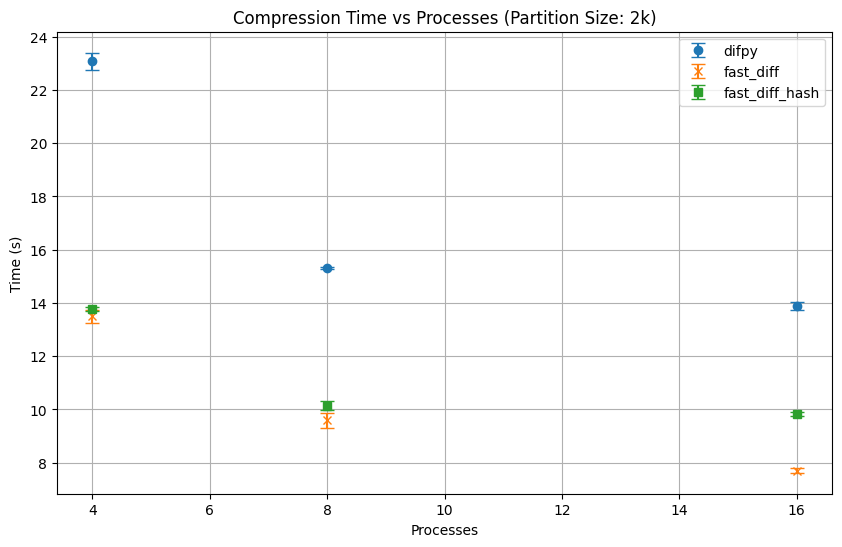

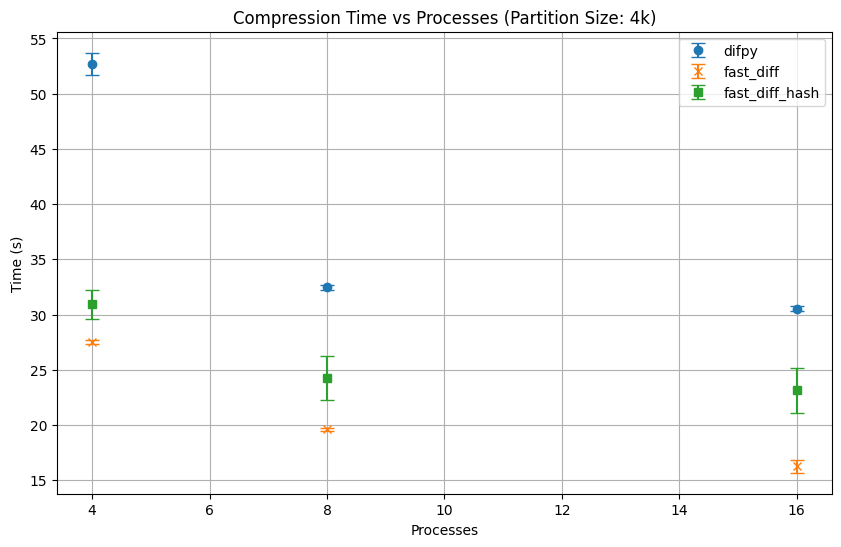

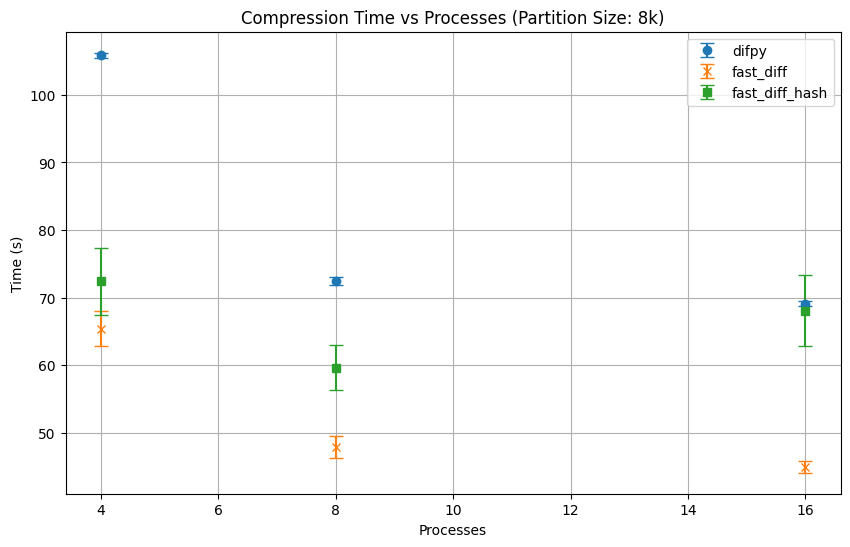

In [39]:
# Compression Time MEAN and STD. Resolved by Partition

sizes = ["2k", "4k", "8k"]

for size in sizes:

    # Filter only compression operation and partition size 2k
    df_compression = df[(df["operation"] == "compression") & (df["partition size"] == size)]

    # Calculate mean and standard deviation for each group
    grouped = df_compression.groupby(["algorithm", "processes"])
    summary = grouped["time"].agg(["mean", "std"]).reset_index()

    # Ensure 'processes' column is numerical and sorted
    summary['processes'] = pd.to_numeric(summary['processes'])
    summary = summary.sort_values(by="processes").reset_index(drop=True)


    # Plot the data
    plt.figure(figsize=(10, 6))

    for algorithm, marker in zip(["difpy", "fast_diff", "fast_diff_hash"], ["o", "x", "s"]):
        subset = summary[summary["algorithm"] == algorithm]

        # Scatter plot with error bars for standard deviation
        plt.errorbar(subset["processes"], subset["mean"], yerr=subset["std"], fmt=marker, label=f"{algorithm}", capsize=5)

    # Add labels, legend, and title
    plt.xlabel("Processes")
    plt.ylabel("Time (s)")
    plt.title(f"Compression Time vs Processes (Partition Size: {size})")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

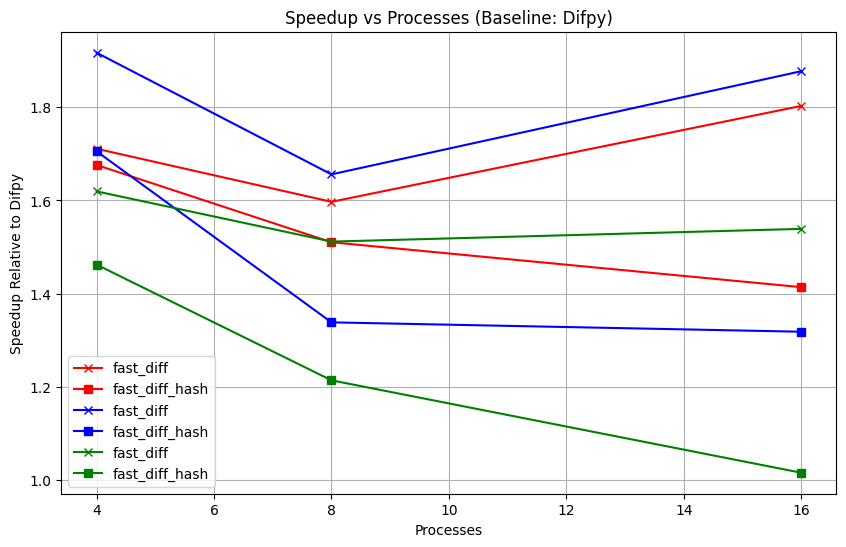

In [41]:
# Plot the data
plt.figure(figsize=(10, 6))

for size, color in {"2k": "red", "4k": "blue", "8k": "green"}.items():
    # Filter only compression operation and partition size 2k
    df_compression = df[(df["operation"] == "compression") & (df["partition size"] == size)]

    # Calculate the baseline using difpy for each process class
    baseline = df_compression[df_compression["algorithm"] == "difpy"].groupby("processes")["time"].mean()

    # Add a column for speedup relative to difpy
    speedup_data = []
    for (algorithm, processes), group in df_compression.groupby(["algorithm", "processes"]):
        if algorithm != "difpy":
            mean_time = group["time"].mean()
            speedup = baseline[processes] / mean_time
            speedup_data.append({"algorithm": algorithm, "processes": processes, "speedup": speedup})

    speedup_df = pd.DataFrame(speedup_data)

    for algorithm, marker in zip(["fast_diff", "fast_diff_hash"], ["x", "s"]):
        subset = speedup_df[speedup_df["algorithm"] == algorithm]
        if subset.empty:
            raise ValueError(f"No data found for algorithm: {algorithm}")

        # Plot speedup
        plt.plot(subset["processes"], subset["speedup"], label=f"{algorithm}", marker=marker, color=color)

# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Speedup Relative to Difpy")
plt.title(f"Speedup vs Processes (Baseline: Difpy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Deduplication Benchmark

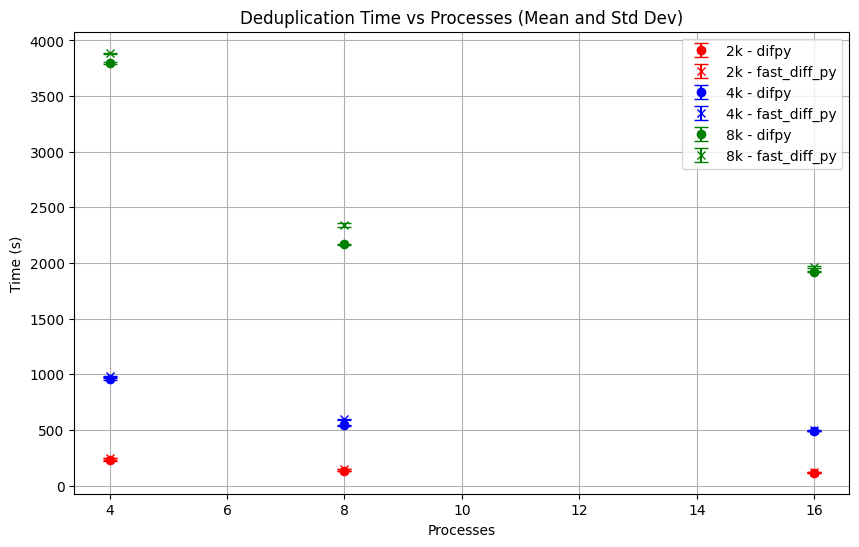

In [42]:
df_dedup = df[(df["operation"] == "deduplication")]

# Group the data by partition size, algorithm, and processes
df_compression_grouped = df_dedup.groupby(["partition size", "algorithm", "processes"]).agg(
    mean_time=("time", "mean"),
    std_time=("time", "std")
).reset_index()

# Define the colors for each partition size
colors = {"2k": "red", "4k": "blue", "8k": "green"}
# colors = {"2k": "red"}

# Plot the data
plt.figure(figsize=(10, 6))

for partition_size, color in colors.items():
    # Get the subset of the data for difpy and fast_diff_py for the current partition size
    subset_difpy = df_compression_grouped[(df_compression_grouped["partition size"] == partition_size) & (df_compression_grouped["algorithm"] == "difpy")]
    subset_fast_diff_py = df_compression_grouped[(df_compression_grouped["partition size"] == partition_size) & (df_compression_grouped["algorithm"] == "fast_diff_py")]

    # Plot mean with error bars for difpy
    plt.errorbar(
        subset_difpy["processes"],
        subset_difpy["mean_time"],
        yerr=subset_difpy["std_time"],
        label=f"{partition_size} - difpy",
        color=color,
        fmt="o",
        capsize=5
    )
    # Plot mean with error bars for fast_diff_py
    plt.errorbar(
        subset_fast_diff_py["processes"],
        subset_fast_diff_py["mean_time"],
        yerr=subset_fast_diff_py["std_time"],
        label=f"{partition_size} - fast_diff_py",
        color=color,
        fmt="x",
        capsize=5
    )


# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Time (s)")
plt.title("Deduplication Time vs Processes (Mean and Std Dev)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


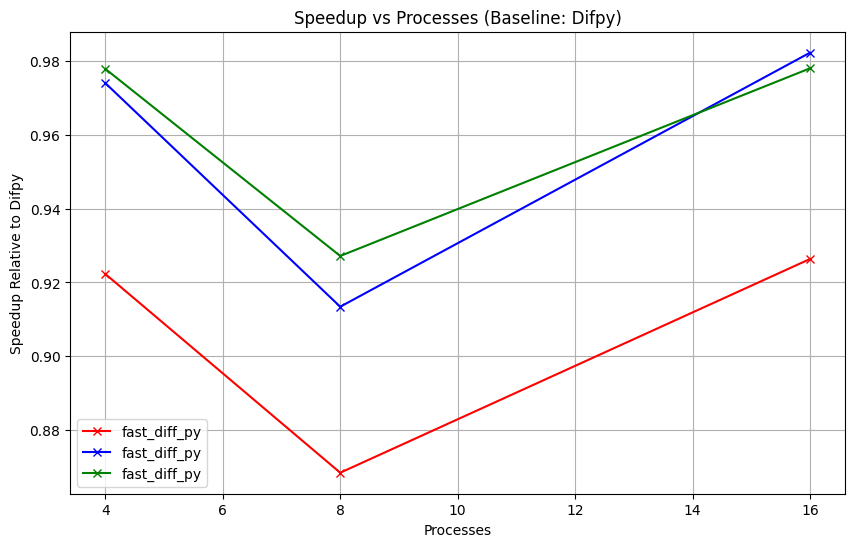

In [43]:
# Plot the data
plt.figure(figsize=(10, 6))

for size, color in {"2k": "red", "4k": "blue", "8k": "green"}.items():
    # Filter only compression operation and partition size 2k
    df_compression = df[(df["operation"] == "deduplication") & (df["partition size"] == size)]

    # Calculate the baseline using difpy for each process class
    baseline = df_compression[df_compression["algorithm"] == "difpy"].groupby("processes")["time"].mean()

    # Add a column for speedup relative to difpy
    speedup_data = []
    for (algorithm, processes), group in df_compression.groupby(["algorithm", "processes"]):
        if algorithm != "difpy":
            mean_time = group["time"].mean()
            speedup = baseline[processes] / mean_time
            speedup_data.append({"algorithm": algorithm, "processes": processes, "speedup": speedup})

    speedup_df = pd.DataFrame(speedup_data)

    for algorithm, marker in zip(["fast_diff_py"], ["x", "s"]):
        subset = speedup_df[speedup_df["algorithm"] == algorithm]
        if subset.empty:
            raise ValueError(f"No data found for algorithm: {algorithm}")

        # Plot speedup
        plt.plot(subset["processes"], subset["speedup"], label=f"{algorithm}", marker=marker, color=color)

# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Speedup Relative to Difpy")
plt.title(f"Speedup vs Processes (Baseline: Difpy)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Benchmark Full Script

Benchmark the `dif.py` script from `difPy` and from `fast_diff_py`

In [44]:
# file = "../benchmark_all_stats_2024-12-23_11-03-57.json"
# with open(file, "r") as f:
#     data = json.load(f)
#
# import os
#
# full_script_data = []
#
# for key1, value1 in data.items():
#     for key2, value2 in value1.items():
#         strip_key2 = os.path.basename(key2.replace("/dir_a", "")).split("_")[1]
#         for key3, value3 in value2.items():
#             for i in range(len(value3)):
#                 val = float("nan") if value3[i] == -1 else value3[i]
#                 full_script_data.append((key1, strip_key2, key3, i, val))
#
# df = pd.DataFrame(full_script_data, columns=["algorithm", "partition size", "processes", "iteration", "time"])
# df.to_csv("./benchmark_full_data.csv")
df = pd.read_csv("../scratch/benchmark_full_data.csv")

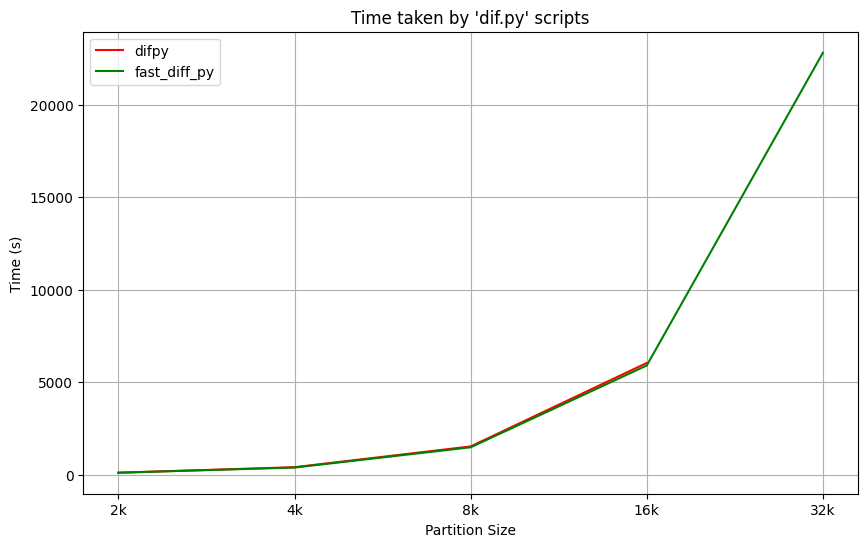

In [58]:
f = plt.figure(figsize=(10, 6))


def forward(x):
    return np.sqrt(x)

def inverse(x):
    return np.square(x)

for algorithm, color in {"difpy": "red", "fast_diff_py": "green"}.items():
    df_compression = df[(df["algorithm"] == algorithm)]

    plt.plot(df_compression["partition size"], df_compression["time"], label=algorithm, color=color)

# f.axes[0].set_yscale('function', functions=(forward, inverse))

# Add labels, legend, and title
plt.xlabel("Partition Size")
plt.ylabel("Time (s)")
plt.title(f"Time taken by scripts")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

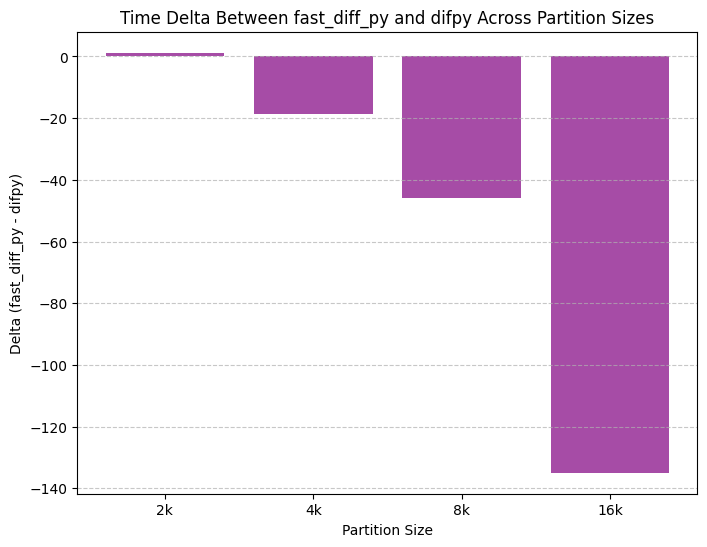

In [26]:
plt.figure(figsize=(10, 6))

# Filter out rows where 'time' is NaN for either algorithm
df = df.dropna(subset=["time"])

# Pivot the data to calculate deltas
pivot_df = df.pivot(index="partition size", columns="algorithm", values="time")
pivot_df["delta"] = pivot_df["fast_diff_py"] - pivot_df["difpy"]

# Define a custom sorting order for partition sizes
partition_order = ["2k", "4k", "8k", "16k", "32k"]

# Sort the DataFrame by the custom order
pivot_df = pivot_df.reindex(partition_order)

# Plot the delta
plt.figure(figsize=(8, 6))
plt.bar(pivot_df.index, pivot_df["delta"], color="purple", alpha=0.7)

# Add labels, title, and grid
plt.xlabel("Partition Size")
plt.ylabel("Delta (fast_diff_py - difpy)")
plt.title("Time Delta Between fast_diff_py and difpy Across Partition Sizes")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


# Discarded

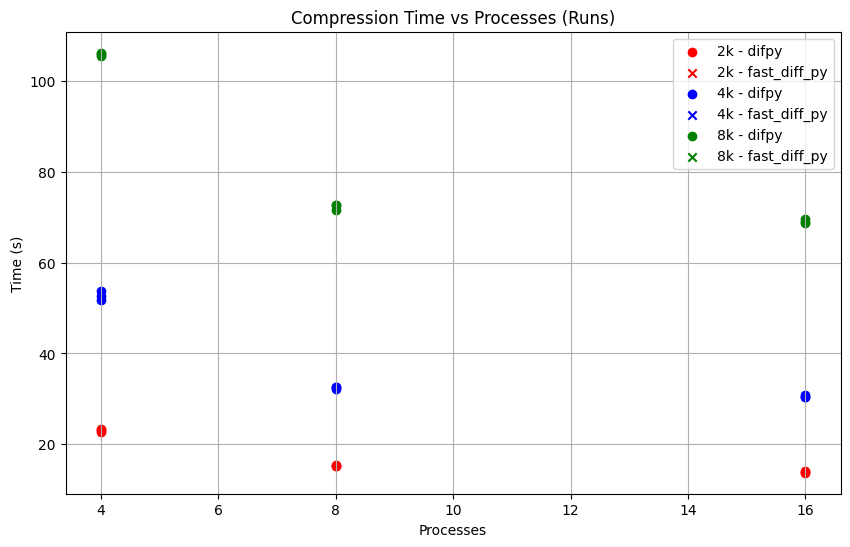

In [4]:
# Compression Time vs Processes (Displaying Runs over STD and MEAN)

colors = {"2k": "red", "4k": "blue", "8k": "green"}

# Plot the data
plt.figure(figsize=(10, 6))

for partition_size, color in colors.items():
    subset_difpy = df_compression[(df_compression["partition size"] == partition_size) & (df_compression["algorithm"] == "difpy")]
    subset_fast_diff_py = df_compression[(df_compression["partition size"] == partition_size) & (df_compression["algorithm"] == "fast_diff_py")]

    # Scatter plot for difpy
    plt.scatter(subset_difpy["processes"], subset_difpy["time"], label=f"{partition_size} - difpy", color=color, marker="o")
    # Scatter plot for fast_diff_py
    plt.scatter(subset_fast_diff_py["processes"], subset_fast_diff_py["time"], label=f"{partition_size} - fast_diff_py", color=color, marker="x")

# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Time (s)")
plt.title("Compression Time vs Processes (Runs)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


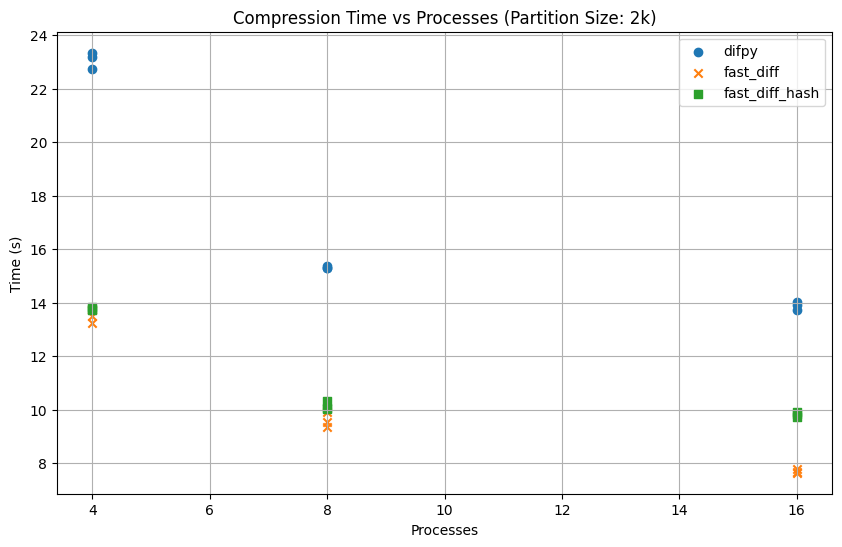

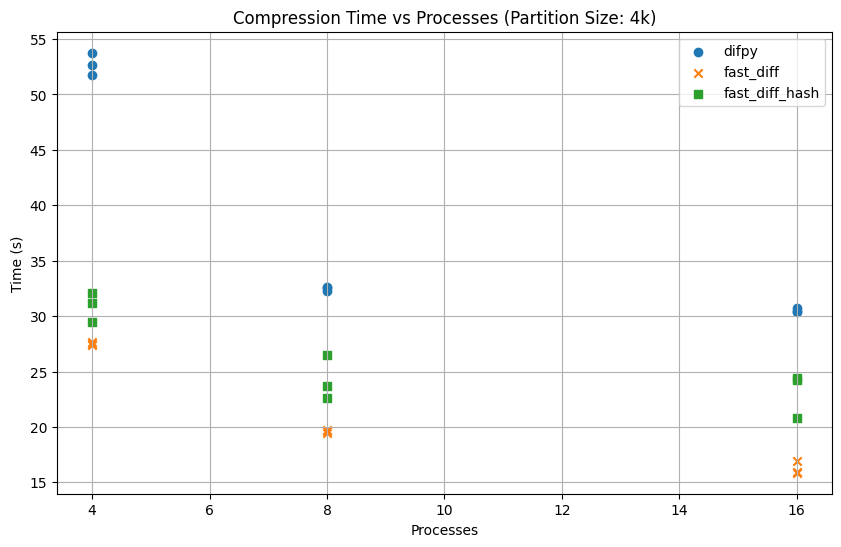

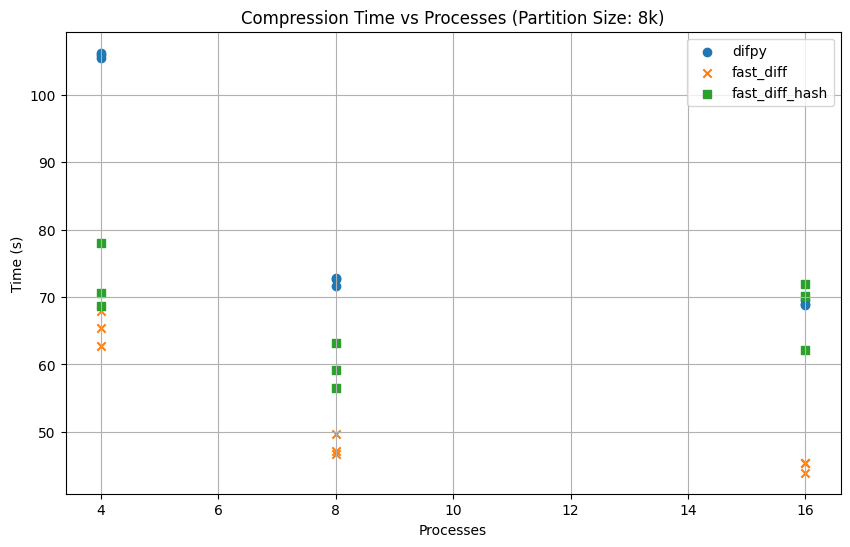

In [9]:
# Compression Time VS Processes (Resolved by Partition, and Runs)

sizes = ["2k", "4k", "8k"]

for size in sizes:

    # Filter only compression operation and partition size 2k
    df_compression = df[(df["operation"] == "compression") & (df["partition size"] == size)]

    # Plot the data
    plt.figure(figsize=(10, 6))

    for algorithm, marker in zip(["difpy", "fast_diff", "fast_diff_hash"], ["o", "x", "s"]):
        subset = df_compression[df_compression["algorithm"] == algorithm]
        if subset.empty:
            raise ValueError(f"No data found for algorithm: {algorithm}")

        # Scatter plot of all values
        plt.scatter(subset["processes"], subset["time"], label=f"{algorithm}", marker=marker)

    # Add labels, legend, and title
    plt.xlabel("Processes")
    plt.ylabel("Time (s)")
    plt.title(f"Compression Time vs Processes (Partition Size: {size})")
    plt.legend()
    plt.grid(True)

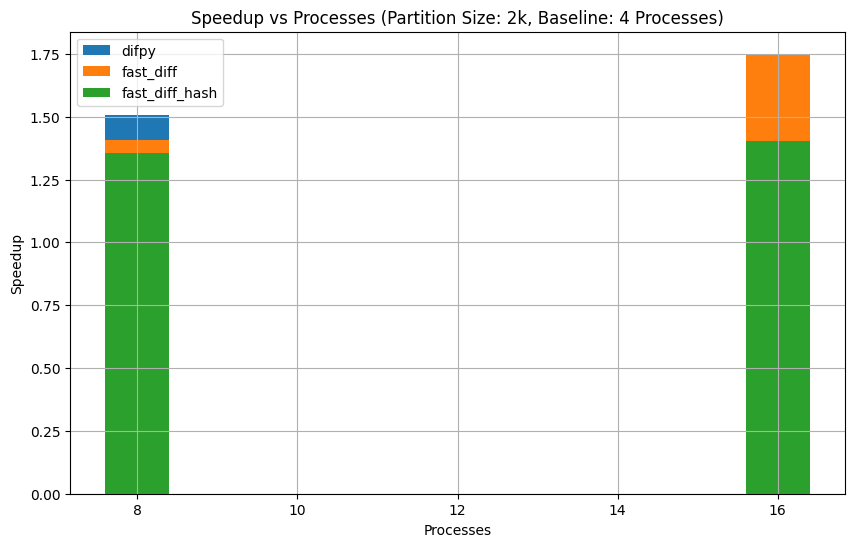

In [7]:
# Speedup vs Processes, Single Size (2k)

# Filter only compression operation and partition size 2k
df_compression = df[(df["operation"] == "compression") & (df["partition size"] == "2k")]

# Calculate the baseline (processes == 4) for each algorithm
baseline = df_compression[df_compression["processes"] == 4].groupby("algorithm")["time"].mean()

# Add a column for speedup
speedup_data = []
for (algorithm, processes), group in df_compression.groupby(["algorithm", "processes"]):
    mean_time = group["time"].mean()
    if processes in [8, 16]:
        speedup = baseline[algorithm] / mean_time
        speedup_data.append({"algorithm": algorithm, "processes": processes, "speedup": speedup})

speedup_df = pd.DataFrame(speedup_data)

# Plot the data
plt.figure(figsize=(10, 6))

for algorithm, marker in zip(["difpy", "fast_diff", "fast_diff_hash"], ["o", "x", "s"]):
    subset = speedup_df[speedup_df["algorithm"] == algorithm]
    if subset.empty:
        raise ValueError(f"No data found for algorithm: {algorithm}")

    # Plot speedup
    plt.bar(subset["processes"], subset["speedup"], label=f"{algorithm}")

# Add labels, legend, and title
plt.xlabel("Processes")
plt.ylabel("Speedup")
plt.title("Speedup vs Processes (Partition Size: 2k, Baseline: 4 Processes)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

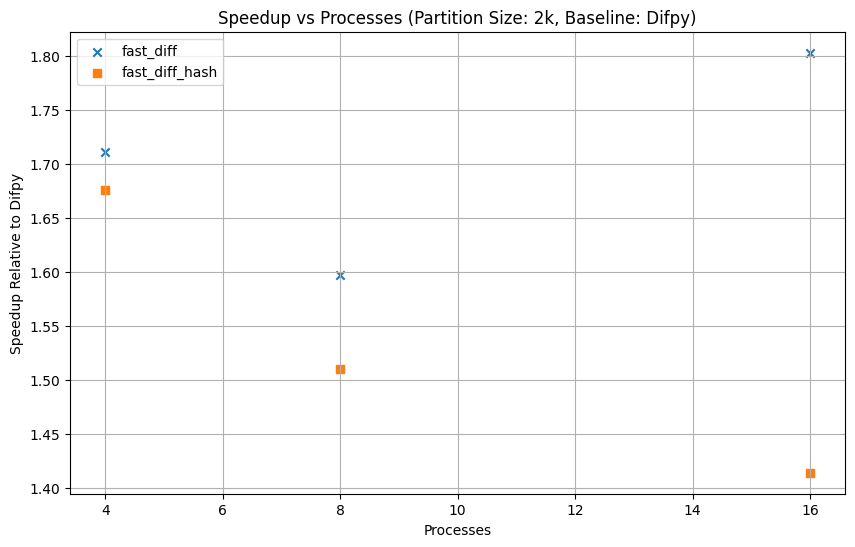

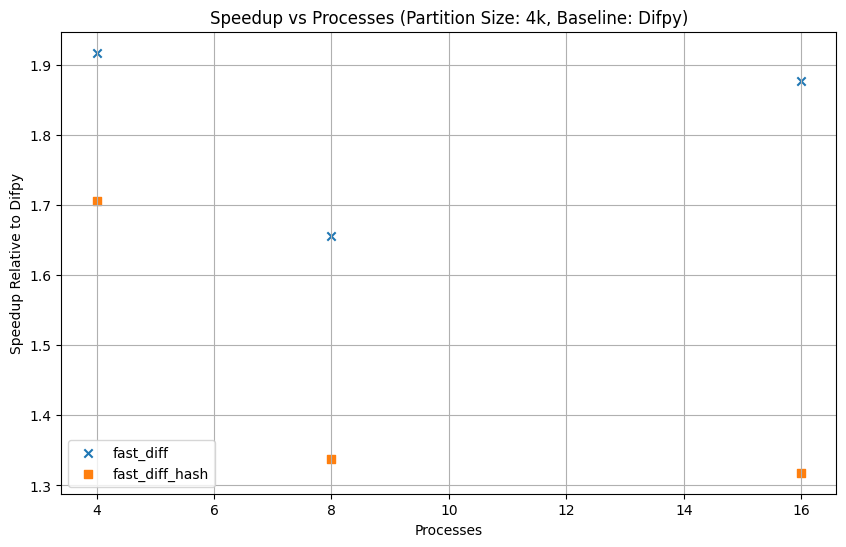

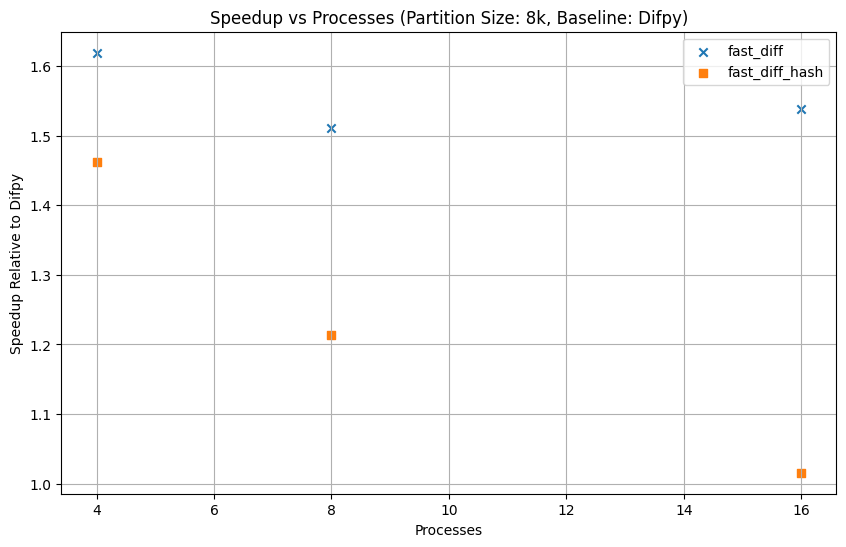

In [8]:
# Speedup vs Process (Mean) Resolved by Partition Size

for size in ("2k", "4k", "8k"):
    # Filter only compression operation and partition size 2k
    df_compression = df[(df["operation"] == "compression") & (df["partition size"] == size)]

    # Calculate the baseline using difpy for each process class
    baseline = df_compression[df_compression["algorithm"] == "difpy"].groupby("processes")["time"].mean()

    # Add a column for speedup relative to difpy
    speedup_data = []
    for (algorithm, processes), group in df_compression.groupby(["algorithm", "processes"]):
        if algorithm != "difpy":
            mean_time = group["time"].mean()
            speedup = baseline[processes] / mean_time
            speedup_data.append({"algorithm": algorithm, "processes": processes, "speedup": speedup})

    speedup_df = pd.DataFrame(speedup_data)

    # Plot the data
    plt.figure(figsize=(10, 6))

    for algorithm, marker in zip(["fast_diff", "fast_diff_hash"], ["x", "s"]):
        subset = speedup_df[speedup_df["algorithm"] == algorithm]
        if subset.empty:
            raise ValueError(f"No data found for algorithm: {algorithm}")

        # Plot speedup
        plt.scatter(subset["processes"], subset["speedup"], label=f"{algorithm}", marker=marker)

    # Add labels, legend, and title
    plt.xlabel("Processes")
    plt.ylabel("Speedup Relative to Difpy")
    plt.title(f"Speedup vs Processes (Partition Size: {size}, Baseline: Difpy)")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()
